Importing required libary & setting up GPU



In [ ]:
import torch
from torch import nn
from torchvision import datasets
from torchvision.transforms import ToTensor,Normalize,Compose
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.utils import class_weight
from torch.utils.data import DataLoader

device='cuda' if torch.cuda.is_available() else 'cpu'

Data preparation

In [ ]:
#download dataset from torch vision
train_data=datasets.MNIST(
    root='Data',
    train=True,
    download=True,
    transform=Compose([
        ToTensor()
        ]))
test_data=datasets.MNIST(
    root='Data',
    train=False,
    download=True,
    transform=Compose([
        ToTensor()
        ]))

100%|██████████| 9912422/9912422 [00:00<00:00, 32612007.48it/s]


Extracting Data/MNIST/raw/train-images-idx3-ubyte.gz to Data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 13405897.94it/s]

Extracting Data/MNIST/raw/train-labels-idx1-ubyte.gz to Data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 26302865.74it/s]


Extracting Data/MNIST/raw/t10k-images-idx3-ubyte.gz to Data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 13568752.68it/s]


Extracting Data/MNIST/raw/t10k-labels-idx1-ubyte.gz to Data/MNIST/raw



In [ ]:
#dataloader
traindata_loader=DataLoader(
    train_data,
    batch_size=32,
    shuffle=True
)
tesdata_loader=DataLoader(
    test_data,
    batch_size=32,
    shuffle=False
)

Train Data

In [ ]:
xtrain=[]
ytrain=[]
for (img,lbl) in train_data:
  xtrain.append(img)
  ytrain.append(lbl)
xtrain=torch.stack(xtrain)
ytrain=torch.tensor(ytrain)

Test Data

In [ ]:
samples=[]
labels=[]
pred=[]
for sample,lbl in test_data:
  samples.append(sample)
  labels.append(lbl)
samples=torch.stack(samples)
samples=samples.to(device)
labels=torch.tensor(labels)

Data Visualization

10


<ipython-input-6-01d356980ff4>:2: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3614.)
  plt.imshow(xtrain[0].T)


10

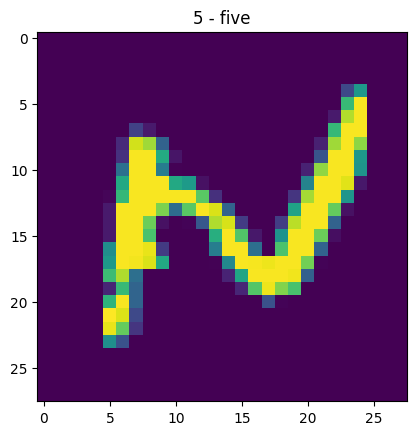

In [ ]:
label=train_data.classes
plt.imshow(xtrain[0].T)
plt.title(label[ytrain[0]])
print(len(label))
len(label)

CNN Model

In [ ]:
class cnn (nn.Module):
  def __init__(self,input:int,output:int,hidden:int) :
    super().__init__()
    self.block1=nn.Sequential(
        nn.Conv2d(
            in_channels=input,
            out_channels=hidden,
            kernel_size=3,
            stride=1,
            padding=1
        ),
        nn.ReLU(),
        nn.Conv2d(
            in_channels=hidden,
            out_channels=hidden,
            kernel_size=3,
            stride=1,
            padding=1
        ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.block2=nn.Sequential(
        nn.Conv2d(
            in_channels=hidden,
            out_channels=hidden,
            kernel_size=3,
            stride=1,
            padding=1
        ),
        nn.ReLU(),
        nn.Conv2d(
            in_channels=hidden,
            out_channels=hidden,
            kernel_size=3,
            stride=1,
            padding=1
        ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.classifier=nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden*7*7,out_features=output)
    )
  def forward(self,x):
    x=self.block1(x)
    x=self.block2(x)
    x=self.classifier(x)
    return(x)
model=cnn(input=1,output=10,hidden=10)

Spaced Learning

In [ ]:
class spaced_learning():
    def __init__(self, n_nn=10):
        self.n_nn = n_nn

    def fit(self, X, y, pred):
        self.models = []
        ensemble_weights = []
        base_acc=100
        for _ in range(self.n_nn):
            print(_)
            x_samp, y_samp = self._bootstraped(X, y)
            weight = self._class_weight(y_samp)

            model_copy = self._train(DataLoader(TensorDataset(x_samp, y_samp), batch_size=32), weight.to(device))
            accuracy = self._calculate_accuracy(model_copy,samples,labels)

            if(_==1):
              base_acc=accuracy

            if(accuracy>base_acc):
              self.models.append(model_copy)
              ensemble_weights.append(accuracy)
        ensemble_weights = np.array(ensemble_weights) / sum(ensemble_weights)

        self.ensemble_weights = ensemble_weights

    def _train(self, X, w):
        model_copy = model.to(device)
        optim = torch.optim.SGD(params=model_copy.parameters(), lr=0.01)
        loss_fn = nn.CrossEntropyLoss(w.float())
        epochs =15
        for epoch in range(epochs):
            for batch, (X_batch, y_batch) in enumerate(X):
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                model_copy.train()
                ypred = model_copy(X_batch)
                sample_weights = torch.where(ypred.argmax(dim=1) == y_batch, 1.0, 2.0)
                pre_w_loss=loss_fn(ypred.squeeze() , y_batch)
                loss = (pre_w_loss * sample_weights).mean()
                print(f"pre_weight{pre_w_loss}||loss{loss}||epoch{epoch}||batch{batch}||sample_w={sample_weights}")
                optim.zero_grad()
                loss.backward()
                optim.step()
        return model_copy

    def _calculate_accuracy(self,model, x_test,y_test):
        model.eval()
        correct = 0
        total = 0
        y_preds=[]
        with torch.no_grad():
              y_pred = model(x_test)
        y_pred=y_pred.argmax(dim=1)
        y_pred=torch.tensor(y_pred)
        y_train=torch.tensor(y_test)
        correct = torch.eq(y_train.to(device), y_pred.to(device)).sum().item()
        acc = (correct / len(y_pred)) * 100
        return acc


    def _find_split(self,X):
      z=X
      avg=((np.sum([1/i[0] for i in enumerate(z,start=1)])))
      avgs=len(X)*avg
      return round(avgs)

    def _class_weight(self,y):
      class_n=np.bincount(y)
      class_count=class_n.shape[0]
      total_samp=y.shape[0]
      class_weights = []
      for count in class_n:
          weight = total_samp / (count * class_count)
          class_weights.append(weight)
      class_weights=torch.tensor(class_weights)
      return class_weights

    def _bootstraped(self, X, y):
        n_samps = X.shape[0]
        size = (self._find_split(label))*1000
        idx = np.random.choice(n_samps, size, replace=False)
        return X[idx], y[idx]

    def _voting(self, predictions, weights):
        if isinstance(predictions[0], np.ndarray):
            weighted_predictions = np.vstack([p * w for p, w in zip(predictions, weights)])
            return np.sum(weighted_predictions, axis=0)
        else:
            weighted_counts = np.bincount(np.array(predictions), weights=np.array(weights))
            return weighted_counts.argmax()

    def predict(self, X):
        X = torch.tensor(X, dtype=torch.float32)
        predictions = []
        for i, model in enumerate(self.models):
          model.eval()
          with torch.no_grad():
            ypred = model(X)
            ypred = torch.argmax(ypred, dim=1).cpu().numpy()
            predictions.append(ypred)

        ensemble_predictions = [self._voting(p, self.ensemble_weights) for p in zip(*predictions)]
        return ensemble_predictions

Training

In [ ]:
model0=spaced_learning()
model0.fit(xtrain, ytrain, train_data)

Streaming output truncated to the last 5000 lines.
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
pre_weight0.23075562715530396||loss0.24517783522605896||epoch12||batch220||sample_w=tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 1., 1.,
        1., 1., 1., 1., 1., 2., 1., 1., 1., 1., 1., 1., 1., 1.])
pre_weight0.010442182421684265||loss0.010442182421684265||epoch12||batch221||sample_w=tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
pre_weight0.029043974354863167||loss0.02995159849524498||epoch12||batch222||sample_w=tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
pre_weight0.03342454507946968||loss0.034469060599803925||epoch12||batch223||sample_w=tensor([1., 1., 1., 1., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1

<ipython-input-8-f27e9e821123>:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred=torch.tensor(y_pred)
<ipython-input-8-f27e9e821123>:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train=torch.tensor(y_test)


Streaming output truncated to the last 5000 lines.
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
pre_weight7.058991468511522e-05||loss7.058991468511522e-05||epoch11||batch876||sample_w=tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
pre_weight3.2591378840152174e-05||loss3.259137520217337e-05||epoch11||batch877||sample_w=tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
pre_weight0.011351441964507103||loss0.011351442895829678||epoch11||batch878||sample_w=tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
pre_weight0.011798642575740814||loss0.011798642575740814||epoch11||batch879||sample_w=tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 

Make Prediction

In [ ]:
pred=model0.predict(samples)

Prediction Visualization

In [ ]:
label=train_data.classes

plt.figure(figsize=(9,9))
row=3
col=3
for i,sample in enumerate(samples):
  plt.subplot(row,col,i+1)
  plt.imshow(sample.to('cpu').T)
  pred_label=label[pred[i]]
  real=label[labels[i]]
  plt.title(f"real= {real}||predicted= {pred_label}",fontsize=8)
  plt.axis(False)